In [14]:
from google.colab import files
uploaded = files.upload()

Saving new_data.csv to new_data (1).csv


In [15]:
from google.colab import files
uploaded = files.upload()

Saving f1sim-ref-left.csv to f1sim-ref-left (1).csv
Saving f1sim-ref-line.csv to f1sim-ref-line (1).csv
Saving f1sim-ref-right.csv to f1sim-ref-right (1).csv
Saving f1sim-ref-turns.csv to f1sim-ref-turns (1).csv


In [16]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
df = pd.read_csv("new_data.csv")
df

,lap_id,invalid_lap,BPS_SPEED,BPS_THROTTLE,BPS_STEER,BPS_BRAKE,BPS_LAPDISTANCE,BPS_WORLDPOSITIONX,BPS_WORLDPOSITIONY,BPS_WORLDFORWARDDIRX,...,APX2_YAW,APX2_PITCH,APX2_ROLL,APX2_left_dist,APX2_dist_apex_1,APX2_dist_apex_2,APX2_angle_to_apex1,APX2_angle_to_apex2,APX2_proj_from_ref,Target_CURRENTLAPTIMEINMS
0,10021698834789871149_1,1,316.0,1.000000,0.074568,0.0,223.0,274.071987,313.458779,-23579.0,...,-2.906792,0.002597,-0.015706,1.188303,101.216786,1.468423,176.387023,-73.297876,1.243211,15377
1,10021698834789871149_10,1,324.0,0.970802,0.000464,0.0,273.0,310.096901,278.846172,-23824.0,...,-2.975512,-0.004548,-0.010439,1.716472,101.368594,0.941933,178.312192,-68.980181,0.715854,12146
2,10021698834789871149_11,1,322.0,1.000000,-0.002375,0.0,258.0,298.743940,288.688005,-23746.0,...,-2.922204,-0.003019,-0.011373,2.731520,101.668646,0.122973,176.987177,53.851467,0.297512,12220
3,10021698834789871149_12,0,322.0,0.025177,0.006011,0.0,269.0,307.165908,281.569461,-23818.0,...,-2.923212,-0.002735,-0.009557,1.879479,101.417020,0.779785,177.377583,-68.683995,0.553155,12219
4,10021698834789871149_13,1,324.0,1.000000,0.021114,0.0,268.0,306.397540,282.215448,-23831.0,...,-2.824224,0.006822,-0.014098,4.818916,102.315233,2.167787,173.829692,99.915419,2.381417,12881
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
820,9874269645241895165_2,1,144.0,0.000000,-0.525250,0.0,450.0,369.369267,134.915112,5165.0,...,-2.974651,-0.000140,-0.022406,2.409240,105.101572,7.066486,179.753790,-120.396863,5.033546,13686
821,9941972541231747669_1,1,324.0,1.000000,0.000000,0.0,263.0,302.615240,285.497492,-23572.0,...,-2.875317,-0.000517,-0.010140,1.617995,101.340908,1.039864,176.906931,-71.039304,0.814210,12490
822,9941972541231747669_2,0,324.0,1.000000,-0.000000,0.0,264.0,303.184481,284.646456,-23649.0,...,-2.914761,-0.002244,-0.008611,1.437935,101.289007,1.219306,177.457928,-71.360891,0.993987,12326
823,9948558370850722411_1,1,324.0,1.000000,-0.003344,0.0,276.0,301.987594,286.287858,-24030.0,...,-2.907833,0.001437,-0.014618,2.980371,101.744896,0.340118,175.711551,87.320007,0.545892,13604


# Template for modelling at one point

In [17]:
# This one has a crazy good RMSE idk how but that's definitely not the case
# after modelling all features together rip
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import lightgbm

TARGET = "Target_CURRENTLAPTIMEINMS"
PREDICTORS = [
    'Target_CURRENTLAPTIMEINMS',
    'BPS_LAPDISTANCE',
    'BPS_WORLDPOSITIONX',
    'BPS_WORLDPOSITIONY',
    'BPS_STEER',
    'BPS_BRAKE',
    'BPS_THROTTLE',
    'BPS_SPEED',
]

y = df[TARGET]
# log-transform target (stabilize variance)
y_log = np.log1p(y)
X = df[PREDICTORS].copy()

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_log, test_size=0.2, random_state=42
)

lgbm = LGBMRegressor(
    n_estimators=1200,
    learning_rate=0.03,
    max_depth=-1,
    num_leaves=63,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
    verbosity=-1
)

lgbm.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric="rmse",
    callbacks=[lightgbm.log_evaluation(0)]
)

# Predict (invert log) & metrics
y_pred_log = lgbm.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_test)

# Test metrics
r2 = r2_score(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# Train metrics
train_pred_log = lgbm.predict(X_train)
train_pred = np.expm1(train_pred_log)
train_true = np.expm1(y_train)
train_rmse = np.sqrt(mean_squared_error(train_true, train_pred))

print(f"Train RMSE: {train_rmse:.3f} ms")
print(f"Test RMSE:  {rmse:.3f} ms")
print(f"Test R²:    {r2:.3f}")

# Single row of predictors + prediction
i = 0
sample = X_test.iloc[i]
pred_value = y_pred[i]

print(f"BPS_LAPDISTANCE: {sample['BPS_LAPDISTANCE']:.2f}")
print(f"BPS_CURRENTLAPTIMEINMS: {np.expm1(y_test.iloc[i]):,.2f}")
print(f"BPS_WORLDPOSITIONX: {sample['BPS_WORLDPOSITIONX']:.4f}")
print(f"BPS_WORLDPOSITIONY: {sample['BPS_WORLDPOSITIONY']:.4f}")
print(f"BPS_STEER:           {sample['BPS_STEER']:.4f}")
print(f"BPS_BRAKE:           {sample['BPS_BRAKE']:.4f}")
print(f"BPS_THROTTLE:        {sample['BPS_THROTTLE']:.4f}")
print(f"BPS_SPEED:           {sample['BPS_SPEED']:.2f}")
print(f"Predicted {TARGET}: {pred_value:,.3f}")

Train RMSE: 776.535 ms
Test RMSE:  1301.304 ms
Test R²:    0.929
BPS_LAPDISTANCE: 275.00
BPS_CURRENTLAPTIMEINMS: 12,272.00
BPS_WORLDPOSITIONX: 311.6848
BPS_WORLDPOSITIONY: 277.6099
BPS_STEER:           0.0000
BPS_BRAKE:           0.0000
BPS_THROTTLE:        1.0000
BPS_SPEED:           324.00
Predicted Target_CURRENTLAPTIMEINMS: 12,171.469


In [18]:
import numpy as np
import pandas as pd

def suggest_best_setup_for_log_model_lgbm(
    model,
    X_train: pd.DataFrame,
    percentiles=(0.05, 0.95),
    N=50_000,
    top_k=5,
    seed=42,
    hard_bounds: dict | None = None,
    int_cols: list[str] | None = None,
):
    rng = np.random.default_rng(seed)

    # numeric columns only
    num_cols = X_train.select_dtypes(include=["number"]).columns
    q = X_train[num_cols].quantile([percentiles[0], percentiles[1]])
    low, high = q.loc[percentiles[0]], q.loc[percentiles[1]]

    # sample candidates
    candidates = {c: rng.uniform(low=low[c], high=high[c], size=N) for c in num_cols}
    Xcand = pd.DataFrame(candidates)[num_cols]

    # enforce hard bounds
    if hard_bounds:
        for c, (lo, hi) in hard_bounds.items():
            if c in Xcand.columns:
                Xcand[c] = np.clip(Xcand[c], lo, hi)

    # cast integer cols
    if int_cols:
        for c in int_cols:
            if c in Xcand.columns:
                Xcand[c] = Xcand[c].round().astype(int)

    # predict in log space then invert
    ypred_ms = np.expm1(model.predict(Xcand))

    # best candidates
    order = np.argsort(ypred_ms)
    best_idx = order[:top_k]

    topk = Xcand.iloc[best_idx].copy()
    topk["Predicted_Target_CURRENTLAPTIMEINMS"] = ypred_ms[best_idx]

    best_setup = topk.iloc[0].drop("Predicted_Target_CURRENTLAPTIMEINMS")
    best_pred  = float(topk.iloc[0]["Predicted_Target_CURRENTLAPTIMEINMS"])
    return topk.reset_index(drop=True), best_setup, best_pred

topk, best_setup, best_pred = suggest_best_setup_for_log_model_lgbm(
    model=lgbm,
    X_train=X_train,
    percentiles=(0.05, 0.95),
    N=50_000,
    top_k=5,
    seed=42,
    hard_bounds={
        # "BPS_THROTTLE": (0.0, 1.0),
        # "BPS_BRAKE":    (0.0, 1.0),
        # "BPS_STEER":    (-1.0, 1.0),
        # "BPS_SPEED":    (0.0, None),  # None → skip clip
    },
    int_cols=[
        # "gear",
    ],
)

print("Suggested optimal setup (within 5–95% train ranges)")
for k, v in best_setup.items():
    print(f"{k}: {v:.4f}")
print(f"Predicted Target_CURRENTLAPTIMEINMS: {best_pred:,.3f} ms")

print("\nTop-5 suggested setups:")
print(topk.to_string(index=False))


Suggested optimal setup (within 5–95% train ranges)
Target_CURRENTLAPTIMEINMS: 12444.9464
BPS_LAPDISTANCE: 278.4381
BPS_WORLDPOSITIONX: 331.0538
BPS_WORLDPOSITIONY: 271.7105
BPS_STEER: 0.0308
BPS_BRAKE: 0.0000
BPS_THROTTLE: 0.7624
BPS_SPEED: 292.9042
Predicted Target_CURRENTLAPTIMEINMS: 12,009.554 ms

Top-5 suggested setups:
 Target_CURRENTLAPTIMEINMS  BPS_LAPDISTANCE  BPS_WORLDPOSITIONX  BPS_WORLDPOSITIONY  BPS_STEER  BPS_BRAKE  BPS_THROTTLE  BPS_SPEED  Predicted_Target_CURRENTLAPTIMEINMS
              12444.946411       278.438053          331.053784          271.710535   0.030806        0.0      0.762384 292.904157                         12009.554063
              12442.645955       285.391726          332.306984          253.166376   0.033350        0.0      0.764238 277.028111                         12051.588308
              12375.391075       256.847604          323.995457          274.948171   0.015898        0.0      0.346654 283.870212                         12136.760338
 

In [19]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd

# Config
TARGET = "Target_CURRENTLAPTIMEINMS"

# Feature groups
BPS_FEATS = [
    "BPS_LAPDISTANCE","BPS_WORLDPOSITIONX","BPS_WORLDPOSITIONY",
    "BPS_STEER","BPS_BRAKE","BPS_THROTTLE","BPS_SPEED"
]

BPE_FEATS = [
    "BPE_LAPDISTANCE","BPE_WORLDPOSITIONX","BPE_WORLDPOSITIONY",
    "BPE_STEER","BPE_BRAKE","BPE_THROTTLE","BPE_SPEED"
]

STS_FEATS = [
    "STS_LAPDISTANCE","STS_WORLDPOSITIONX","STS_WORLDPOSITIONY",
    "STS_STEER","STS_BRAKE","STS_THROTTLE","STS_SPEED"
]

STM_FEATS = [
    "STM_LAPDISTANCE","STM_WORLDPOSITIONX","STM_WORLDPOSITIONY",
    "STM_STEER","STM_BRAKE","STM_THROTTLE","STM_SPEED"
]

STE_FEATS = [
    "STE_LAPDISTANCE","STE_WORLDPOSITIONX","STE_WORLDPOSITIONY",
    "STE_STEER","STE_BRAKE","STE_THROTTLE","STE_SPEED"
]

THS_FEATS = [
    "THS_LAPDISTANCE","THS_WORLDPOSITIONX","THS_WORLDPOSITIONY",
    "THS_STEER","THS_BRAKE","THS_THROTTLE","THS_SPEED"
]

THE_FEATS = [
    "THE_LAPDISTANCE","THE_WORLDPOSITIONX","THE_WORLDPOSITIONY",
    "THE_STEER","THE_BRAKE","THE_THROTTLE","THE_SPEED"
]

APX1_FEATS = [
    "APX1_LAPDISTANCE","APX1_WORLDPOSITIONX","APX1_WORLDPOSITIONY",
    "APX1_STEER","APX1_BRAKE","APX1_THROTTLE","APX1_SPEED"
]

APX2_FEATS = [
    "APX2_LAPDISTANCE","APX2_WORLDPOSITIONX","APX2_WORLDPOSITIONY",
    "APX2_STEER","APX2_BRAKE","APX2_THROTTLE","APX2_SPEED"
]

COMBINED_FEATS = sorted(list(set(
    BPS_FEATS + BPE_FEATS + STS_FEATS + STM_FEATS + STE_FEATS + THS_FEATS +
    THE_FEATS + APX1_FEATS + APX2_FEATS
)))

# Data & helpers
y = df[TARGET].astype(float)
y_log = np.log1p(y)

def split_xy(feats):
    X = df[feats].copy()
    return train_test_split(X, y_log, test_size=0.2, random_state=42)

def build_lgbm():
    return LGBMRegressor(
        n_estimators=1200,
        learning_rate=0.03,
        max_depth=-1,
        num_leaves=63,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        random_state=42,
        n_jobs=-1,
        verbosity=-1
    )

def eval_model(X_train, X_test, y_train, y_test, model):
    model.fit(X_train, y_train)
    # test
    y_pred = np.expm1(model.predict(X_test))
    y_true = np.expm1(y_test)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    # train
    y_tr_pred = np.expm1(model.predict(X_train))
    y_tr_true = np.expm1(y_train)
    train_rmse = np.sqrt(mean_squared_error(y_tr_true, y_tr_pred))
    return train_rmse, rmse, r2, y_pred, model, X_test, y_test

def run_one(name, feats):
    X_train, X_test, y_train, y_test = split_xy(feats)
    model = build_lgbm()
    tr_rmse, te_rmse, r2, y_pred, model, X_test, y_test = eval_model(
        X_train, X_test, y_train, y_test, model
    )
    return dict(
        Model=name, Train_RMSE_ms=tr_rmse, Test_RMSE_ms=te_rmse, R2=r2,
        X_test=X_test, y_test=y_test, y_pred=y_pred, model=model
    )

# Train runs
runs = []
runs.append(run_one("BPS only", BPS_FEATS))
runs.append(run_one("BPE only", BPE_FEATS))
runs.append(run_one("STS only", STS_FEATS))
runs.append(run_one("STM only", STM_FEATS))
runs.append(run_one("STE only", STE_FEATS))
runs.append(run_one("THS only", THS_FEATS))
runs.append(run_one("THE only", THE_FEATS))
runs.append(run_one("APX1 only", APX1_FEATS))
runs.append(run_one("APX2 only", APX2_FEATS))
runs.append(run_one("Combined", COMBINED_FEATS))

# Comparison table
summary = pd.DataFrame([
    {k: v for k, v in r.items() if k in ["Model", "Train_RMSE_ms", "Test_RMSE_ms", "R2"]}
    for r in runs
]).sort_values("Test_RMSE_ms")

print("Performance comparison")
for _, row in summary.iterrows():
    print(f"{row['Model']:32s} | "
          f"Train RMSE: {row['Train_RMSE_ms']:8.2f} ms | "
          f"Test RMSE: {row['Test_RMSE_ms']:8.2f} ms | "
          f"R²: {row['R2']:6.3f}")

# Sample predictors (grouped) from the combined model
combined = [r for r in runs if r["Model"].startswith("Combined")][0]
i = 0  # choose the row to display
sample = combined["X_test"].iloc[i]
pred_value = combined["y_pred"][i]
actual_value = np.expm1(combined["y_test"].iloc[i])

print("Predictions")
feature_groups = {
    "BPS": BPS_FEATS,
    "BPE": BPE_FEATS,
    "STS": STS_FEATS,
    "STM": STM_FEATS,
    "STE": STE_FEATS,
    "THS": THS_FEATS,
    "THE": THE_FEATS,
    "APX1": APX1_FEATS,
    "APX2": APX2_FEATS,
}
for label, feats in feature_groups.items():
    print(f"\n--- {label} FEATURES ---")
    for col in feats:
        if col in sample.index:
            print(f"{col:25s}: {sample[col]:.4f}")

print(f"\nActual {TARGET}:     {actual_value:,.2f}")
print(f"Predicted {TARGET}:  {pred_value:,.3f}")


Performance comparison
Combined                         | Train RMSE:   272.19 ms | Test RMSE:  3743.43 ms | R²:  0.417
STE only                         | Train RMSE:   760.35 ms | Test RMSE:  4053.40 ms | R²:  0.316
THE only                         | Train RMSE:  1304.36 ms | Test RMSE:  4162.04 ms | R²:  0.279
STM only                         | Train RMSE:   789.84 ms | Test RMSE:  4182.56 ms | R²:  0.272
APX2 only                        | Train RMSE:  1159.63 ms | Test RMSE:  4220.00 ms | R²:  0.258
STS only                         | Train RMSE:  1117.17 ms | Test RMSE:  4280.15 ms | R²:  0.237
THS only                         | Train RMSE:  1051.90 ms | Test RMSE:  4290.38 ms | R²:  0.234
BPE only                         | Train RMSE:  1244.62 ms | Test RMSE:  4453.78 ms | R²:  0.174
BPS only                         | Train RMSE:  1507.84 ms | Test RMSE:  4511.08 ms | R²:  0.153
APX1 only                        | Train RMSE:  1205.18 ms | Test RMSE:  4709.96 ms | R²:  0.076
Predict

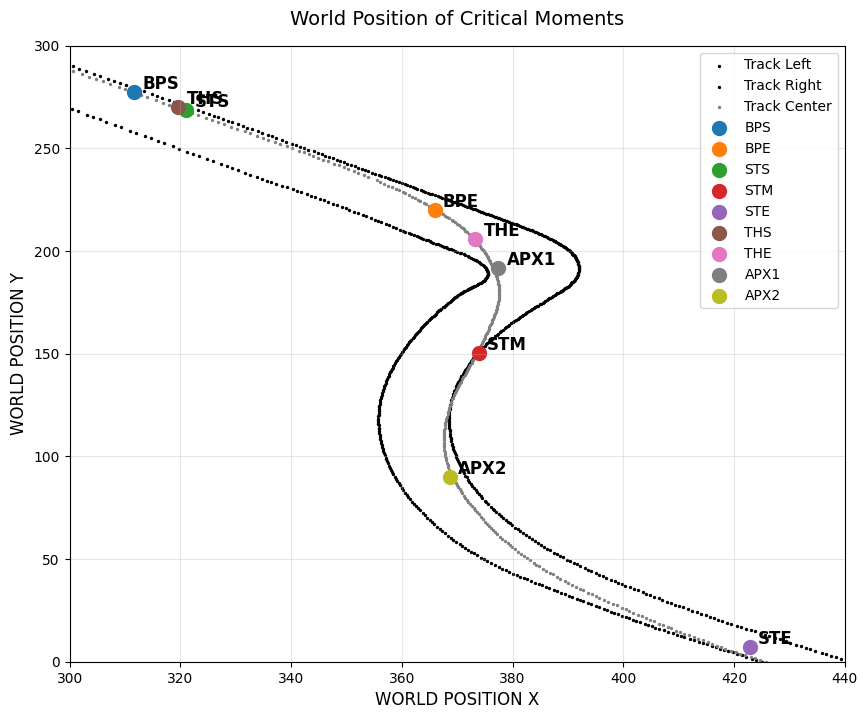

In [21]:
import matplotlib.pyplot as plt

# WORLD POSITION POINTS
points = {
    "BPS": (311.6848, 277.6099),
    "BPE": (365.9415, 220.0245),
    "STS": (321.1038, 268.6421),
    "STM": (373.9233, 150.5832),
    "STE": (422.8397, 7.3199),
    "THS": (319.6550, 270.0222),
    "THE": (373.2967, 206.0868),
    "APX1": (377.4357, 191.9106),
    "APX2": (368.6284, 90.0225),
}

plt.figure(figsize=(10, 8))

# Track boundaries/centerline
plt.scatter(track_left.loc[track_left["FRAME"] <= f,  "WORLDPOSX"],
            track_left.loc[track_left["FRAME"] <= f,  "WORLDPOSY"],
            s=2, color="black", label="Track Left")
plt.scatter(track_right.loc[track_right["FRAME"] <= f, "WORLDPOSX"],
            track_right.loc[track_right["FRAME"] <= f, "WORLDPOSY"],
            s=2, color="black", label="Track Right")
plt.scatter(track_line.loc[track_line["FRAME"] <= f,  "WORLDPOSX"],
            track_line.loc[track_line["FRAME"] <= f,  "WORLDPOSY"],
            s=2, color="gray",  label="Track Center")

# Plot setup
for name, (x, y) in points.items():
    plt.scatter(x, y, s=100, label=name)
    plt.text(x + 1.5, y + 1.5, name, fontsize=12, weight="bold")

# Styling
plt.xlabel("WORLD POSITION X", fontsize=12)
plt.ylabel("WORLD POSITION Y", fontsize=12)
plt.title("World Position of Critical Moments", fontsize=14, pad=15)
plt.grid(alpha=0.3)
plt.legend()
plt.xlim(300, 440)
plt.ylim(0, 300)
plt.show()
